In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [103]:
features = ['captioning', 'paraphrase', 'translation']
features_norm = ['captioning_norm', 'paraphrase_norm', 'translation_norm']

df = pd.read_csv("model_attn.csv")
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning", value="PC", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning-translation", value="PCT", inplace=True)
df["task"].replace(to_replace="paraphrase-translation", value="PT", inplace=True)
df.head()

,captioning,paraphrase,translation,model,task
0,0.0,30813.000244,0.0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,P
1,0.0,31400.000488,0.0,paraphrase/downsample-n-0.5/1/paraphrase_none_...,P
2,0.0,31368.000488,0.0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,P
3,0.0,30575.000000,0.0,paraphrase/downsample-n-none/3/paraphrase_none...,P
4,0.0,31537.999512,0.0,paraphrase/downsample-n-none/2/paraphrase_none...,P


In [105]:
# convert attention scores to distribution
# plot attention proportions in a triangle
# df = pd.read_csv("model_attn_by_sample.csv")
feat_dist = np.array(df[features])
row_sums = feat_dist.sum(axis=1)
feat_dist_norm = feat_dist / row_sums[:, np.newaxis]
for i, feat_norm in enumerate(features_norm):
    df[feat_norm] = feat_dist_norm[:, i]
df.head()

,captioning,paraphrase,translation,model,task,captioning_norm,paraphrase_norm,translation_norm
0,0.0,30813.000244,0.0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,P,0.0,1.0,0.0
1,0.0,31400.000488,0.0,paraphrase/downsample-n-0.5/1/paraphrase_none_...,P,0.0,1.0,0.0
2,0.0,31368.000488,0.0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,P,0.0,1.0,0.0
3,0.0,30575.000000,0.0,paraphrase/downsample-n-none/3/paraphrase_none...,P,0.0,1.0,0.0
4,0.0,31537.999512,0.0,paraphrase/downsample-n-none/2/paraphrase_none...,P,0.0,1.0,0.0


In [106]:
tasks = df.task.unique().tolist()
for task in tasks:
    print('-'*10, 'task:', task.upper(), '-'*10)
    models = df[df.task == task]
    feature_dist = np.array([models[feat].sum() for feat in features_norm])
    feature_dist = feature_dist/feature_dist.sum()
    print('feature_dist:', feature_dist)

---------- task: P ----------
feature_dist: [0. 1. 0.]
---------- task: PC ----------
feature_dist: [0.45682522 0.54317478 0.        ]
---------- task: PCT ----------
feature_dist: [0.32189941 0.29975783 0.37834275]
---------- task: PT ----------
feature_dist: [0.        0.4474389 0.5525611]


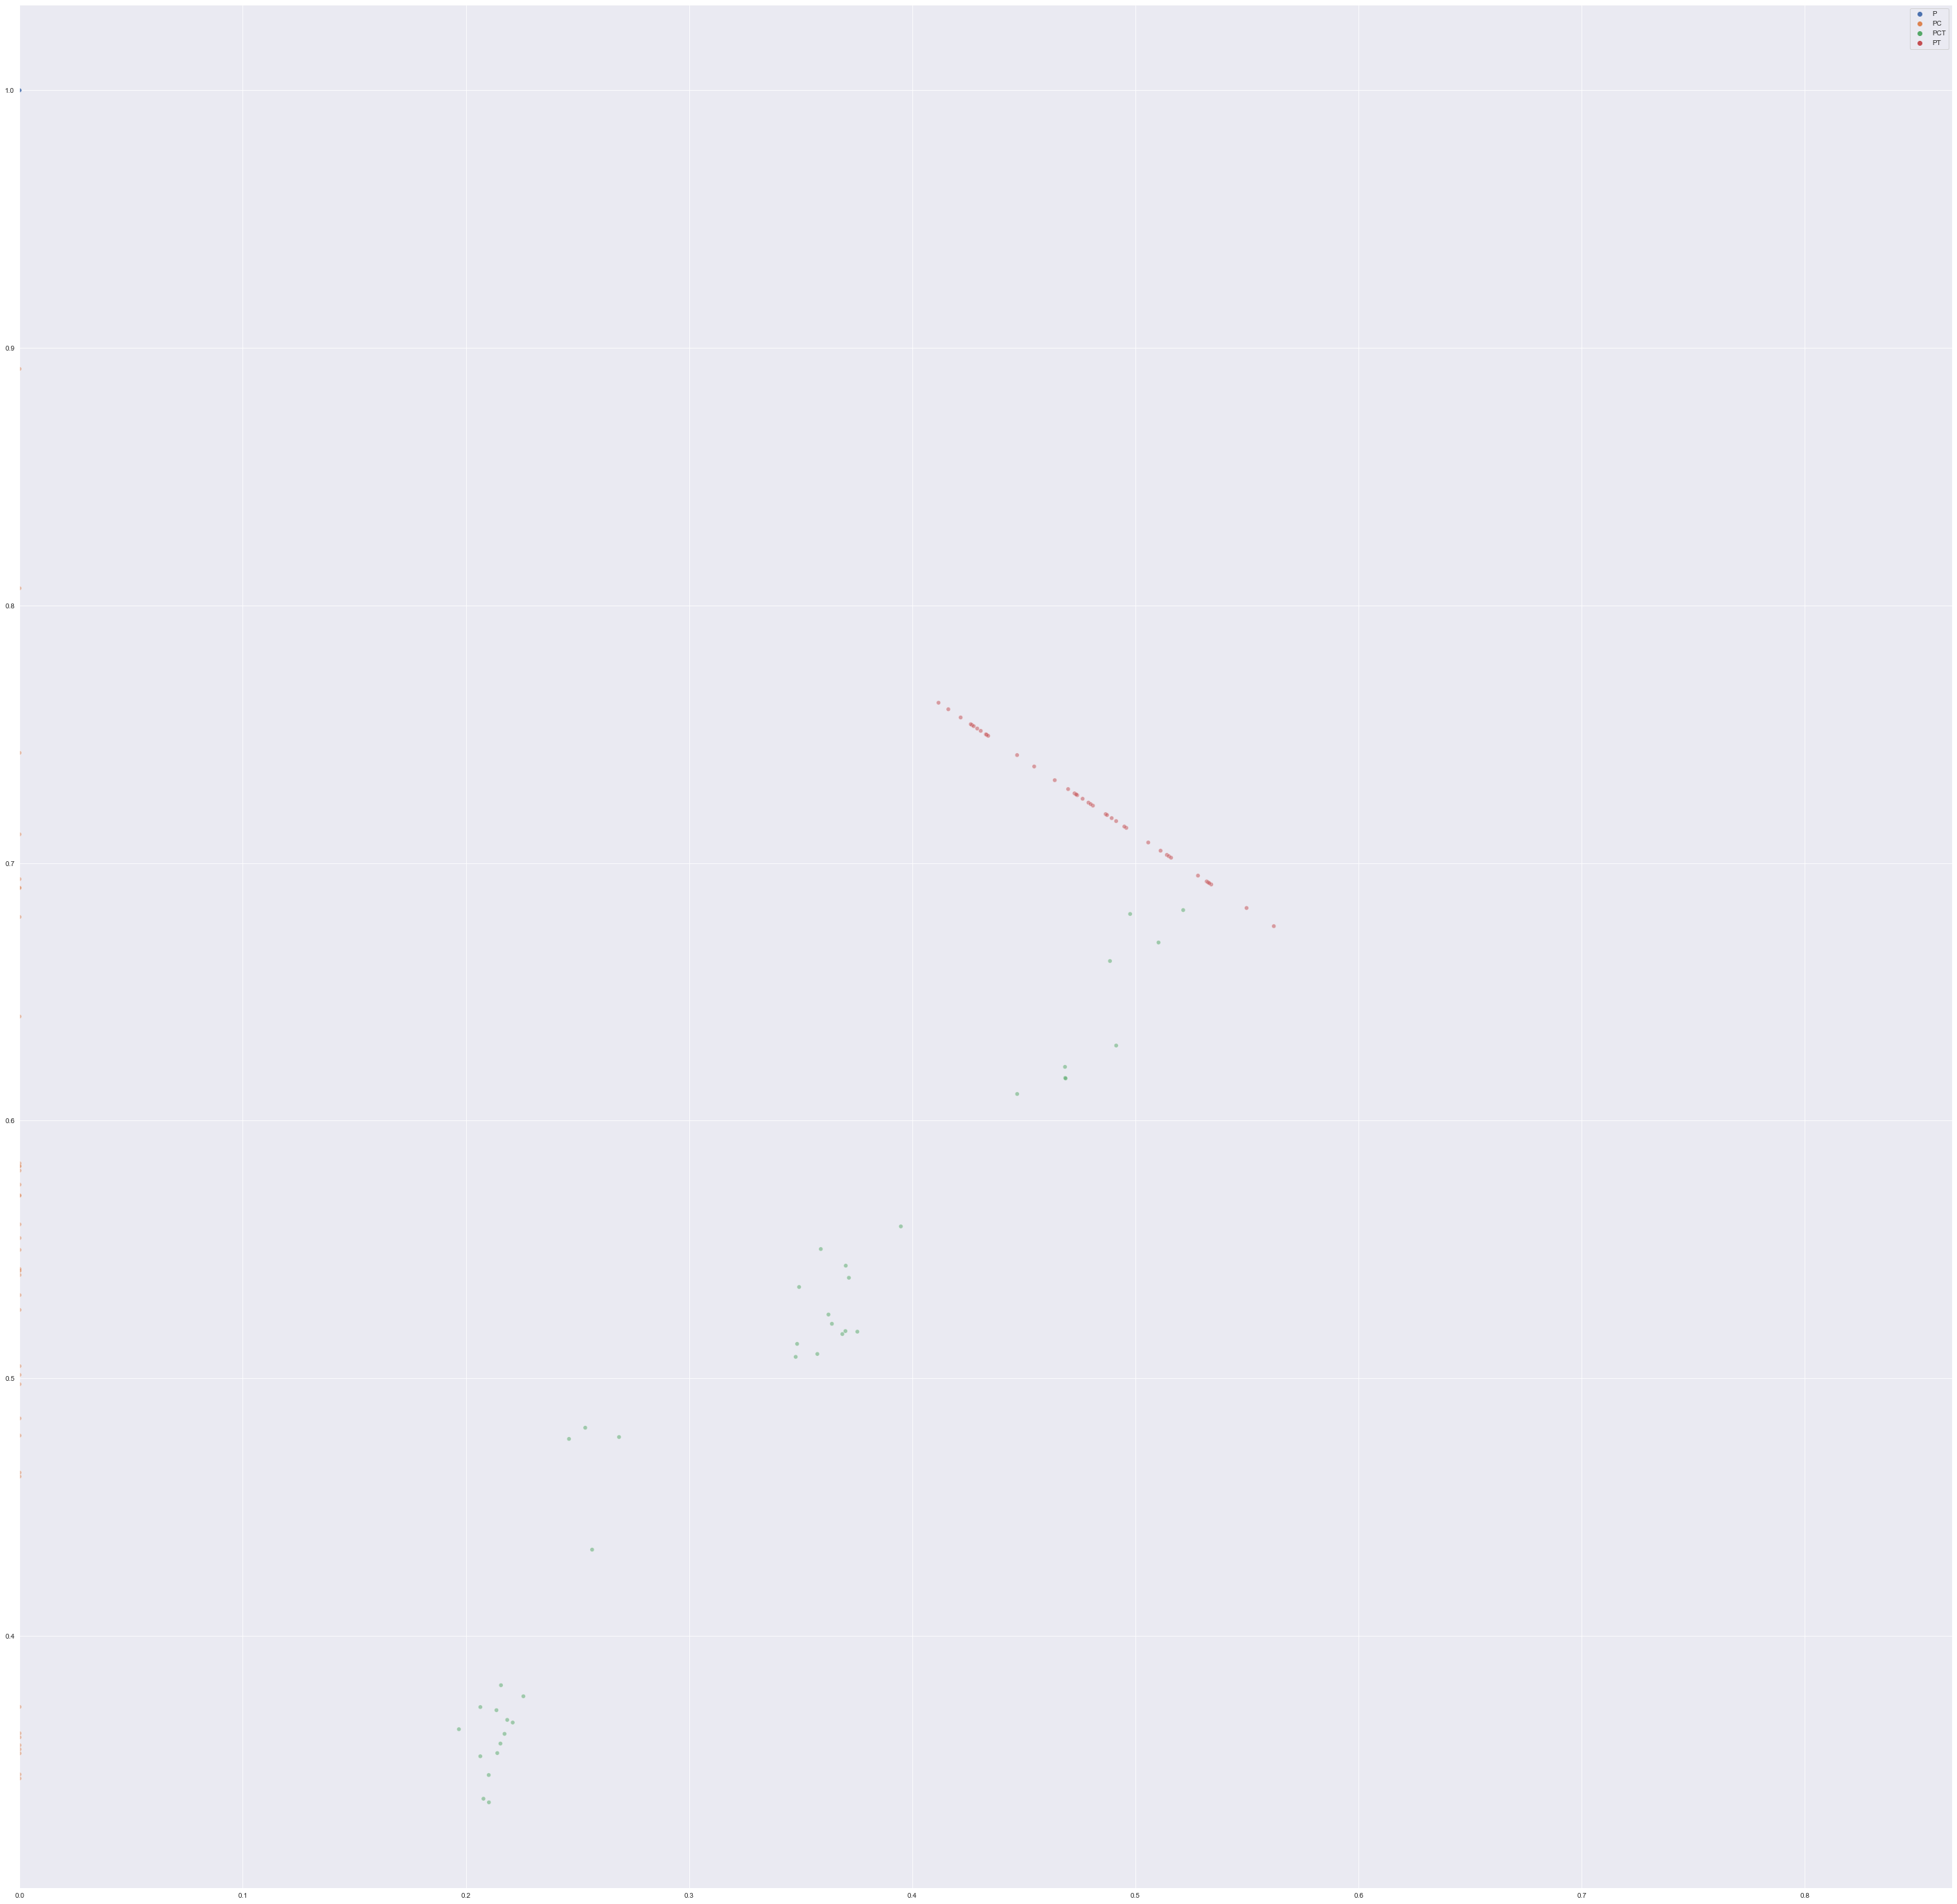

In [107]:
# map 3D points to 2D
map = np.array([[0, 0, np.sqrt(3)/2], [0, 1, 0.5]])
mapped_points = np.matmul(feat_dist_norm, map.T)

# plot 2D points
# plt.scatter(mapped_points[:, 0], mapped_points[:,1], alpha=0.5)
sns.scatterplot(x=mapped_points[:, 0], y=mapped_points[:, 1], hue=df.task.tolist(), alpha=0.5).set(xlim=([0, (3**.5)/2]))
plt.show()

# for sanity check, plot random points
# r = np.random.randn(160, 3)
# mapped_points = np.matmul(map, feat_dist_norm.T)
# random_points = np.matmul(r, map.T)

In [108]:
# correlation between attention distributions and embedding similarity
# compute euclidean distance of attention distributions between every possible pair
# euclidean distance instead of KL div because KL does not work with 0's
import itertools
from sklearn.metrics.pairwise import euclidean_distances

df_wo_p = df[df.task != 'P']

    
dist_dataframe = {'model_1': [],
                  'model_2': [],
                  'task_pair': [],
                  'euclidean': []
                 }
dist = euclidean_distances(X=np.array(df_wo_p[features_norm]), 
                           Y=np.array(df_wo_p[features_norm]))

for x in range(dist.shape[0]):
    for y in range(dist.shape[1]):
        dist_dataframe['model_1'].append(df_wo_p.iloc[x].model)
        dist_dataframe['model_2'].append(df_wo_p.iloc[y].model)
        dist_dataframe['task_pair'].append(df_wo_p.iloc[x].task + "/" + df_wo_p.iloc[y].task)
        dist_dataframe['euclidean'].append(dist[x,y])

# pairs = list(itertools.combinations(range(df_wo_p.shape[0]), 2))
# for pair in pairs:
#    dist_dataframe['model1'].append(df_wo_p.iloc[pair[0]].model)
#    dist_dataframe['model2'].append(df_wo_p.iloc[pair[1]].model)
#    dist_dataframe['task_pair'].append(df_wo_p.iloc[pair[0]].task + "/" + df_wo_p.iloc[pair[1]].task)
#    dist_dataframe['euclidean'].append(dist[pair[0],pair[1]])

In [109]:
dist_dataframe = pd.DataFrame(dist_dataframe)
dist_dataframe.head()

,model_1,model_2,task_pair,euclidean
0,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.000000
1,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.475024
2,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.000204
3,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.070495
4,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.291127


In [110]:
dist_dataframe.task_pair.value_counts().sum()

14400

<AxesSubplot:xlabel='model_2', ylabel='model_1'>

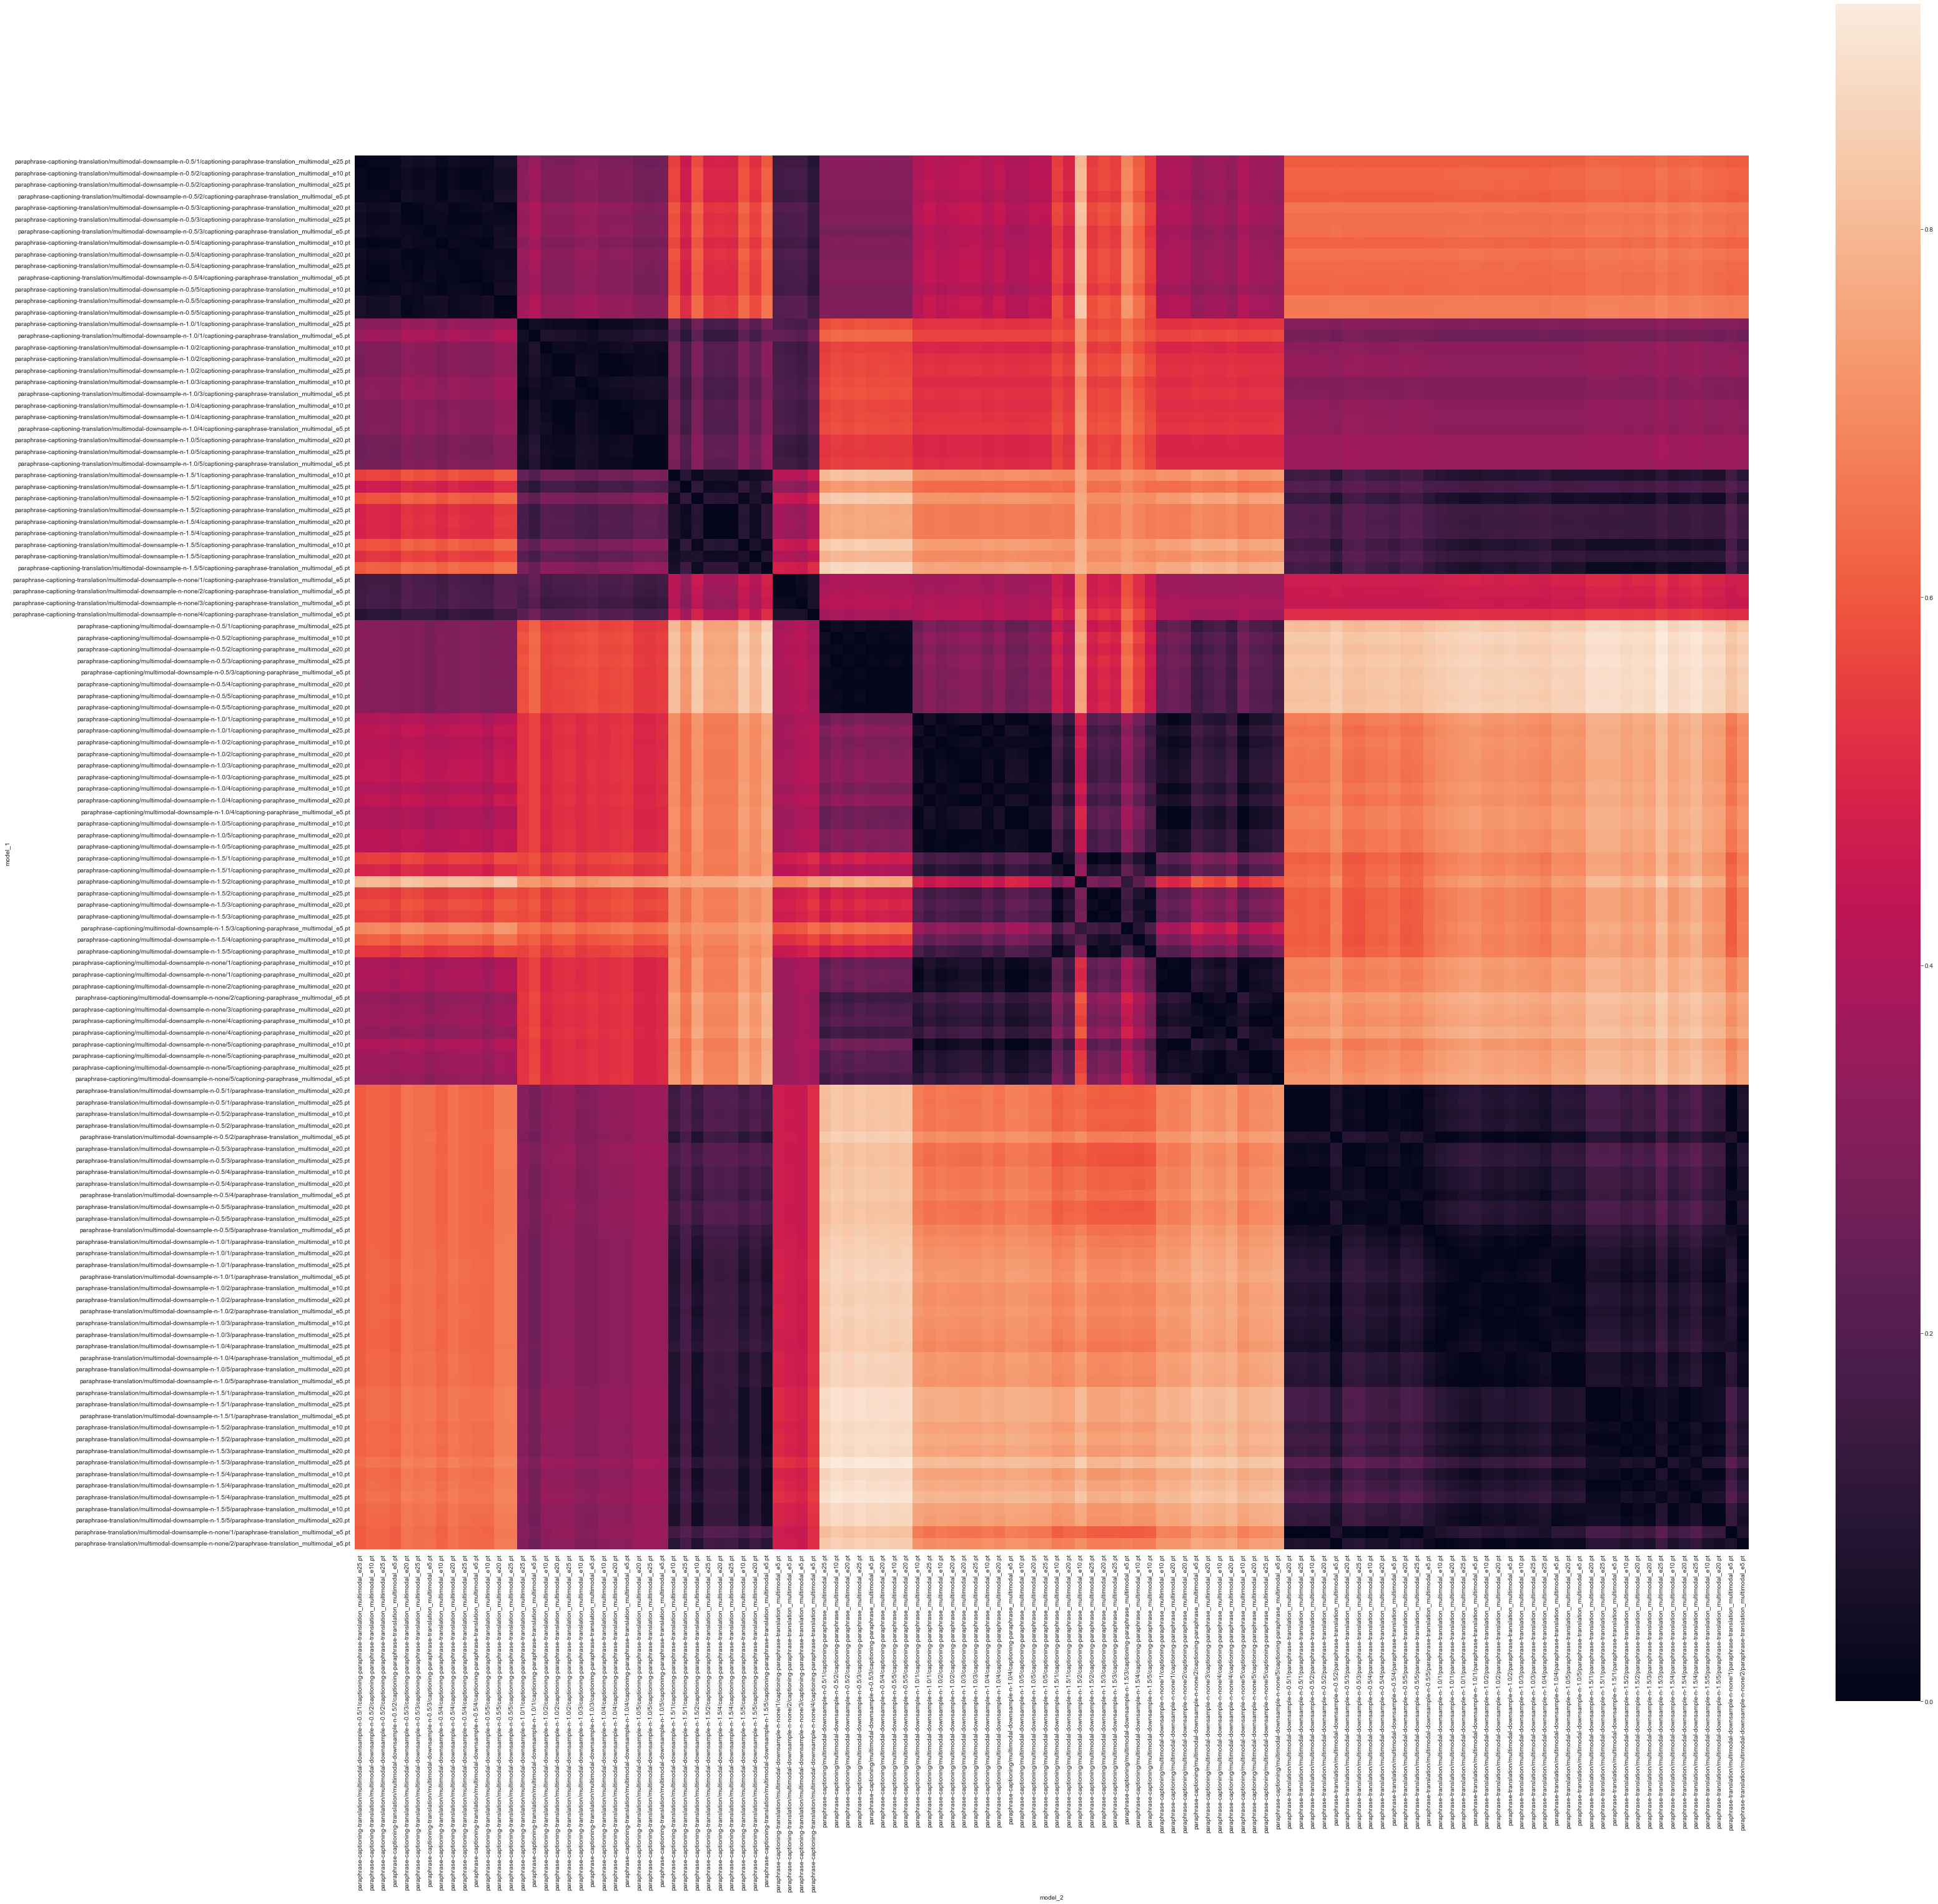

In [111]:
sns.set({'figure.figsize':(50, 50)})

sns.heatmap(
    dist_dataframe.pivot(index='model_1', columns='model_2', values='euclidean'),
    #annot=True,
    #cbar=False,
    square=True,
)

In [112]:
kl_df = pd.read_csv("all-kldivs.multimodal-shortlist.csv")
kl_df.head()

,model_1,model_2,kl_div,agreement
0,models/paraphrase/downsample-n-1.5/5/paraphras...,models/paraphrase/downsample-n-0.5/1/paraphras...,10.116046,0.684519
1,models/paraphrase/downsample-n-0.5/1/paraphras...,models/paraphrase/downsample-n-1.5/5/paraphras...,10.828659,0.684519
2,models/paraphrase/downsample-n-1.5/5/paraphras...,models/paraphrase/downsample-n-1.5/5/paraphras...,6.783998,0.726063
3,models/paraphrase/downsample-n-1.5/5/paraphras...,models/paraphrase/downsample-n-1.5/5/paraphras...,7.218893,0.726063
4,models/paraphrase/downsample-n-1.5/5/paraphras...,models/paraphrase/downsample-n-none/3/paraphra...,9.075919,0.693808


In [113]:
kl_df['model_1'] = [m.split("models/")[1] for m in kl_df.model_1.tolist()]
kl_df['model_2'] = [m.split("models/")[1] for m in kl_df.model_2.tolist()]
kl_df.head()

,model_1,model_2,kl_div,agreement
0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-0.5/1/paraphrase_none_...,10.116046,0.684519
1,paraphrase/downsample-n-0.5/1/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,10.828659,0.684519
2,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,6.783998,0.726063
3,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,7.218893,0.726063
4,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-none/3/paraphrase_none...,9.075919,0.693808


In [114]:
kl_df['model_pair'] = [pair[0]+"#"+pair[1] for pair in zip(kl_df.model_1.tolist(), kl_df.model_2.tolist())]
kl_df.head()

,model_1,model_2,kl_div,agreement,model_pair
0,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-0.5/1/paraphrase_none_...,10.116046,0.684519,paraphrase/downsample-n-1.5/5/paraphrase_none_...
1,paraphrase/downsample-n-0.5/1/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,10.828659,0.684519,paraphrase/downsample-n-0.5/1/paraphrase_none_...
2,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,6.783998,0.726063,paraphrase/downsample-n-1.5/5/paraphrase_none_...
3,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-1.5/5/paraphrase_none_...,7.218893,0.726063,paraphrase/downsample-n-1.5/5/paraphrase_none_...
4,paraphrase/downsample-n-1.5/5/paraphrase_none_...,paraphrase/downsample-n-none/3/paraphrase_none...,9.075919,0.693808,paraphrase/downsample-n-1.5/5/paraphrase_none_...


In [115]:
dist_dataframe['model_pair'] = [pair[0]+"#"+pair[1] for pair in zip(dist_dataframe.model_1.tolist(), dist_dataframe.model_2.tolist())]
dist_dataframe.head()

,model_1,model_2,task_pair,euclidean,model_pair
0,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.000000,paraphrase-captioning/multimodal-downsample-n-...
1,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.475024,paraphrase-captioning/multimodal-downsample-n-...
2,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.000204,paraphrase-captioning/multimodal-downsample-n-...
3,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.070495,paraphrase-captioning/multimodal-downsample-n-...
4,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.291127,paraphrase-captioning/multimodal-downsample-n-...


In [116]:
merged_df = pd.merge(dist_dataframe, kl_df, how='left', on='model_pair')

In [117]:
merged_df = merged_df.dropna()
merged_df.head()

,model_1_x,model_2_x,task_pair,euclidean,model_pair,model_1_y,model_2_y,kl_div,agreement
1,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.475024,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,8.887463,0.692120
2,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.000204,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,8.106355,0.713685
3,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.070495,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,5.946875,0.727340
4,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.291127,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,10.380605,0.672808
5,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,PC/PC,0.323050,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,paraphrase-captioning/multimodal-downsample-n-...,9.491451,0.654196


In [126]:
from scipy.stats import pearsonr
print("Correlation per task pair")
for task_pair in merged_df.task_pair.unique():
    attn_dist = merged_df[merged_df.task_pair == task_pair].euclidean
    kl_pred = merged_df[merged_df.task_pair == task_pair].kl_div
    r = pearsonr(np.array(attn_dist), np.array(kl_pred))
    print(task_pair.upper(), ":", r)
overall_r = pearsonr(np.array(merged_df.euclidean), np.array(merged_df.kl_div))
print("Overall:", overall_r)

Correlation per task pair
PC/PC : (0.3392341908472676, 2.5778576071788013e-43)
PC/PCT : (0.1936728044178192, 5.4979178419012364e-15)
PC/PT : (-0.11115143624799786, 8.334835884899639e-06)
PCT/PC : (0.25823263254450146, 8.654838013149062e-26)
PCT/PCT : (0.26450293054865126, 2.19605831477795e-26)
PCT/PT : (0.0365260581062031, 0.14418352803128598)
PT/PC : (-0.27321879828085527, 8.696543008478986e-29)
PT/PCT : (-0.027712918516862115, 0.2679209132994131)
PT/PT : (0.3485335810054098, 8.821886740844033e-46)
Overall: (0.28910882661077314, 5.533736697376573e-273)
